TASK-1

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import re

class MarketFeatureEngineer:
    def __init__(self, n_levels=20, volatility_windows=[10, 30], volume_windows=[10, 30]):
        """Initialize the feature engineering pipeline."""
        self.n_levels = n_levels
        self.volatility_windows = volatility_windows
        self.volume_windows = volume_windows

    @staticmethod
    def _clean_timestamp(ts_str):
        """Clean and convert timestamp string to datetime."""
        match = re.match(r"^(.*?)(?=\s*[+-]\d{4}\s*\w+$)", ts_str)
        return pd.to_datetime(match.group(1).strip()) if match else pd.to_datetime(ts_str)

    def process_order_book(self, df_orderbook):
        """Process raw order book data and calculate features."""
        print("Processing order book data...")

        df_orderbook = df_orderbook.copy()
        df_orderbook['clean_time'] = df_orderbook['Time'].apply(self._clean_timestamp)
        df_orderbook.set_index('clean_time', inplace=True)

        features = pd.DataFrame(index=df_orderbook.index)
        features['time'] = df_orderbook.index

        features['bid_price'] = df_orderbook['BidPriceL1']
        features['ask_price'] = df_orderbook['AskPriceL1']
        features['mid_price'] = (features['bid_price'] + features['ask_price']) / 2
        features['spread'] = features['ask_price'] - features['bid_price']
        features['spread_bps'] = (features['spread'] / features['mid_price']) * 10000

        bid_qty_l1 = df_orderbook['BidQtyL1']
        ask_qty_l1 = df_orderbook['AskQtyL1']
        features['microprice'] = (
            df_orderbook['BidPriceL1'] * ask_qty_l1 +
            df_orderbook['AskPriceL1'] * bid_qty_l1
        ) / (bid_qty_l1 + ask_qty_l1 + 1e-10)

        for level in range(1, self.n_levels + 1):
            bid_qty = df_orderbook[f'BidQtyL{level}']
            ask_qty = df_orderbook[f'AskQtyL{level}']
            features[f'imbalance_l{level}'] = (bid_qty - ask_qty) / (bid_qty + ask_qty + 1e-10)

        bid_cols = [f'BidQtyL{i}' for i in range(1, self.n_levels + 1)]
        ask_cols = [f'AskQtyL{i}' for i in range(1, self.n_levels + 1)]

        features['total_bid_depth'] = df_orderbook[bid_cols].sum(axis=1)
        features['total_ask_depth'] = df_orderbook[ask_cols].sum(axis=1)
        features['total_imbalance'] = (
            (features['total_bid_depth'] - features['total_ask_depth']) /
            (features['total_bid_depth'] + features['total_ask_depth'] + 1e-10)
        )

        def calculate_slope(prices, quantities):
            if len(prices) < 2 or np.sum(quantities) == 0:
                return np.nan
            log_q = np.log(np.array(quantities) + 1e-10)
            slope, _, _, _, _ = linregress(prices, log_q)
            return slope

        bid_prices_top5 = df_orderbook[[f'BidPriceL{i}' for i in range(1, 6)]].values
        bid_qtys_top5 = df_orderbook[[f'BidQtyL{i}' for i in range(1, 6)]].values
        ask_prices_top5 = df_orderbook[[f'AskPriceL{i}' for i in range(1, 6)]].values
        ask_qtys_top5 = df_orderbook[[f'AskQtyL{i}' for i in range(1, 6)]].values

        features['bid_slope'] = [
            calculate_slope(bid_prices_top5[i], bid_qtys_top5[i])
            for i in tqdm(range(len(df_orderbook)), desc='Calculating bid slope')
        ]
        features['ask_slope'] = [
            calculate_slope(ask_prices_top5[i], ask_qtys_top5[i])
            for i in tqdm(range(len(df_orderbook)), desc='Calculating ask slope')
        ]

        for window in self.volatility_windows:
            features[f'return_vol_{window}s'] = (
                np.log(features['mid_price'] / features['mid_price'].shift(1))
                .rolling(window=window, min_periods=max(1, window // 2))
                .std()
            )
            features[f'microprice_vol_{window}s'] = (
                np.log(features['microprice'] / features['microprice'].shift(1))
                .rolling(window=window, min_periods=max(1, window // 2))
                .std()
            )

        return features

    def process_trades(self, df_trades, df_orderbook_features):
        """Process trade data and merge with order book features."""
        print("Processing trade data...")

        df_trades = df_trades.copy()
        df_trades['clean_time'] = df_trades['Time'].apply(self._clean_timestamp)
        df_trades.set_index('clean_time', inplace=True)

        trade_features = pd.DataFrame(index=df_orderbook_features.index)
        df_trades['direction'] = np.where(df_trades['Price'] >= df_trades['Price'].shift(1), 1, -1)

        for window in self.volume_windows:
            roll_window = f'{window}s'
            trade_features[f'total_volume_{window}s'] = (
                df_trades['Quantity'].rolling(roll_window)
                .sum().reindex(df_orderbook_features.index, method='ffill')
            )

            trade_features[f'buy_volume_{window}s'] = (
                df_trades[df_trades['direction'] == 1]['Quantity']
                .rolling(roll_window).sum()
                .reindex(df_orderbook_features.index, method='ffill').fillna(0)
            )

            trade_features[f'sell_volume_{window}s'] = (
                df_trades[df_trades['direction'] == -1]['Quantity']
                .rolling(roll_window).sum()
                .reindex(df_orderbook_features.index, method='ffill').fillna(0)
            )

            trade_features[f'volume_imbalance_{window}s'] = (
                (trade_features[f'buy_volume_{window}s'] - trade_features[f'sell_volume_{window}s']) /
                (trade_features[f'total_volume_{window}s'] + 1e-10)
            )

        trade_features['trade_count_10s'] = (
            df_trades['NumTrades'].rolling('10s')
            .count().reindex(df_orderbook_features.index, method='ffill').fillna(0)
        )

        trade_features['mm_activity_10s'] = (
            df_trades[df_trades['IsMarketMaker']]['Quantity']
            .rolling('10s').sum()
            .reindex(df_orderbook_features.index, method='ffill').fillna(0)
        )

        trade_features['vwap_10s'] = (
            (df_trades['Price'] * df_trades['Quantity']).rolling('10s').sum() /
            (df_trades['Quantity'].rolling('10s').sum() + 1e-10)
        ).reindex(df_orderbook_features.index, method='ffill')

        trade_features['vwap_shift_10s'] = trade_features['vwap_10s'] - trade_features['vwap_10s'].shift(10)

        combined_features = df_orderbook_features.join(trade_features, how='left')
        trade_cols = trade_features.columns.intersection(combined_features.columns)
        combined_features[trade_cols] = combined_features[trade_cols].ffill()

        return combined_features

    def normalize_features(self, df_features):
        """Normalize features using z-score scaling."""
        print("Normalizing features...")

        feature_cols = [col for col in df_features.columns if col not in ['time', 'Time']]
        scaler = StandardScaler()
        normalized = scaler.fit_transform(df_features[feature_cols])

        df_normalized = df_features.copy()
        df_normalized[feature_cols] = normalized
        return df_normalized, scaler


if __name__ == "__main__":
    # Load data
    orderbook_file = "/home/SPAI_ons/health_ai/Tauheed/gfactor2/data/depth20_1000ms/BNBFDUSD_20250317.txt"
    trades_file = "/home/SPAI_ons/health_ai/Tauheed/gfactor2/data/aggTrade/BNBFDUSD_20250317.txt"

    print(f"Loading order book data from {orderbook_file}...")
    df_orderbook = pd.read_csv(orderbook_file)

    print(f"Loading trade data from {trades_file}...")
    df_trades = pd.read_csv(trades_file)

    # Initialize and process (TASK 1 ONLY)
    feature_engineer = MarketFeatureEngineer()
    df_ob_features = feature_engineer.process_order_book(df_orderbook)
    df_all_features = feature_engineer.process_trades(df_trades, df_ob_features)

    # Save raw features (without normalization)
    output_file = "raw_market_features.csv"
    df_all_features.to_csv(output_file, index=False)
    print(f"Feature engineering complete! Raw features saved to {output_file}")


Loading order book data from /home/SPAI_ons/health_ai/Tauheed/gfactor2/data/depth20_1000ms/BNBFDUSD_20250317.txt...
Loading trade data from /home/SPAI_ons/health_ai/Tauheed/gfactor2/data/aggTrade/BNBFDUSD_20250317.txt...
Processing order book data...


Calculating ask slope: 100%|██████████| 85495/85495 [00:03<00:00, 27994.97it/s]


Processing trade data...
Feature engineering complete! Raw features saved to raw_market_features.csv


task2

Explained Variance by PCA Components:
  Component 1: 99.93%
  Component 2: 0.02%
  Component 3: 0.02%
  Total: 99.97%
Component Kurtosis: ['8.39', '2.76', '2.94']


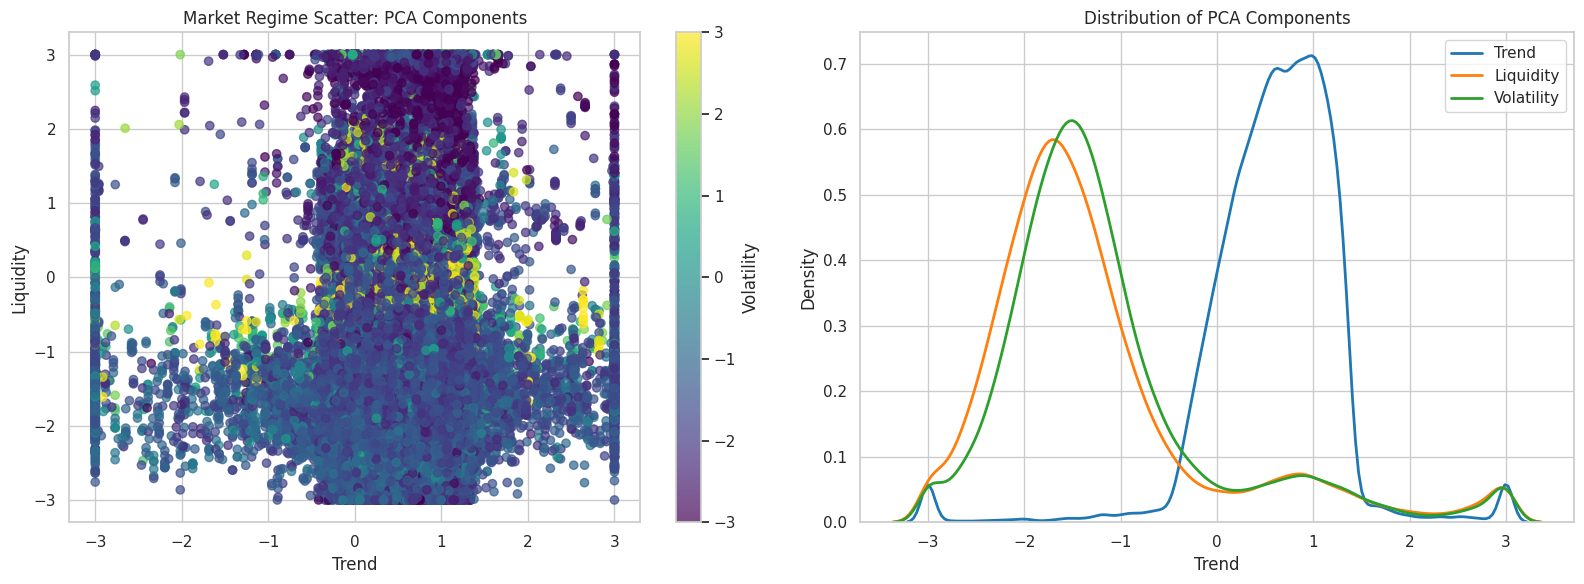


✅ PCA Components saved to 'market_regime_components.csv'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import kurtosis

sns.set(style="whitegrid")

def market_regime_preprocessor(df):
    """
    Robust market regime preprocessing pipeline.
    
    Steps:
    - Outlier handling with MAD clipping
    - Robust normalization
    - Dimensionality reduction using PCA
    - Final normalization for regime clustering

    Args:
        df (pd.DataFrame): Market features (must contain 'time' and core features)

    Returns:
        df_pca (pd.DataFrame): PCA-reduced, normalized features + 'time'
    """

    # -----------------------------
    # 1. Feature Selection
    # -----------------------------
    CORE_FEATURES = [
        'mid_price', 'spread', 
        'total_bid_depth', 'total_ask_depth',
        'return_vol_10s', 'microprice',
        'imbalance_l1', 'volume_imbalance_10s'
    ]
    missing = [f for f in CORE_FEATURES if f not in df.columns]
    if missing:
        raise ValueError(f"Missing required features: {missing}")
    
    features = df[CORE_FEATURES].copy()
    time_col = df['time'].copy()

    # -----------------------------
    # 2. Robust Outlier Clipping
    # -----------------------------
    for col in features.columns:
        med = features[col].median()
        mad = 1.4826 * np.median(np.abs(features[col] - med))
        features[col] = np.clip(features[col], med - 8 * mad, med + 8 * mad)

    # -----------------------------
    # 3. Preprocessing + PCA Pipeline
    # -----------------------------
    pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        RobustScaler(),
        PCA(n_components=3, random_state=42)
    )
    
    X_pca = pipeline.fit_transform(features)
    pca = pipeline.named_steps['pca']

    # -----------------------------
    # 4. Post-PCA Normalization
    # -----------------------------
    for i in range(X_pca.shape[1]):
        low, high = np.percentile(X_pca[:, i], [1, 99])
        X_pca[:, i] = np.interp(X_pca[:, i], (low, high), (-3, 3))

    # -----------------------------
    # 5. Create Output
    # -----------------------------
    df_pca = pd.DataFrame(X_pca, columns=['Trend', 'Liquidity', 'Volatility'])
    df_pca['time'] = time_col

    # -----------------------------
    # 6. Diagnostics
    # -----------------------------
    print("="*50)
    print("Explained Variance by PCA Components:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"  Component {i+1}: {ratio:.2%}")
    print(f"  Total: {pca.explained_variance_ratio_.sum():.2%}")
    print("Component Kurtosis:", 
          [f"{kurtosis(X_pca[:,i]):.2f}" for i in range(3)])
    print("="*50)

    # -----------------------------
    # 7. Visualization
    # -----------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 7a. PCA Scatter Plot
    scatter = ax1.scatter(df_pca['Trend'], df_pca['Liquidity'], 
                          c=df_pca['Volatility'], cmap='viridis', alpha=0.7)
    ax1.set_title("Market Regime Scatter: PCA Components")
    ax1.set_xlabel("Trend")
    ax1.set_ylabel("Liquidity")
    plt.colorbar(scatter, ax=ax1, label="Volatility")

    # 7b. Component Distributions
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, col in enumerate(['Trend', 'Liquidity', 'Volatility']):
        sns.kdeplot(df_pca[col], ax=ax2, label=col, color=colors[i], linewidth=2)
    ax2.set_title("Distribution of PCA Components")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return df_pca

# Example usage
if __name__ == "__main__":
    # Load data
    df_raw = pd.read_csv("/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/raw_market_features.csv")

    # Run preprocessing pipeline
    df_regime = market_regime_preprocessor(df_raw)

    # Save transformed data
    df_regime.to_csv("/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/market_regime_components.csv", index=False)
    print("\n✅ PCA Components saved to 'market_regime_components.csv'")


svd now

Explained Variance by SVD Components:
  Component 1: 99.93%
  Component 2: 0.02%
  Component 3: 0.02%
  Total: 99.97%
Component Kurtosis: ['8.38', '0.63', '1.74']


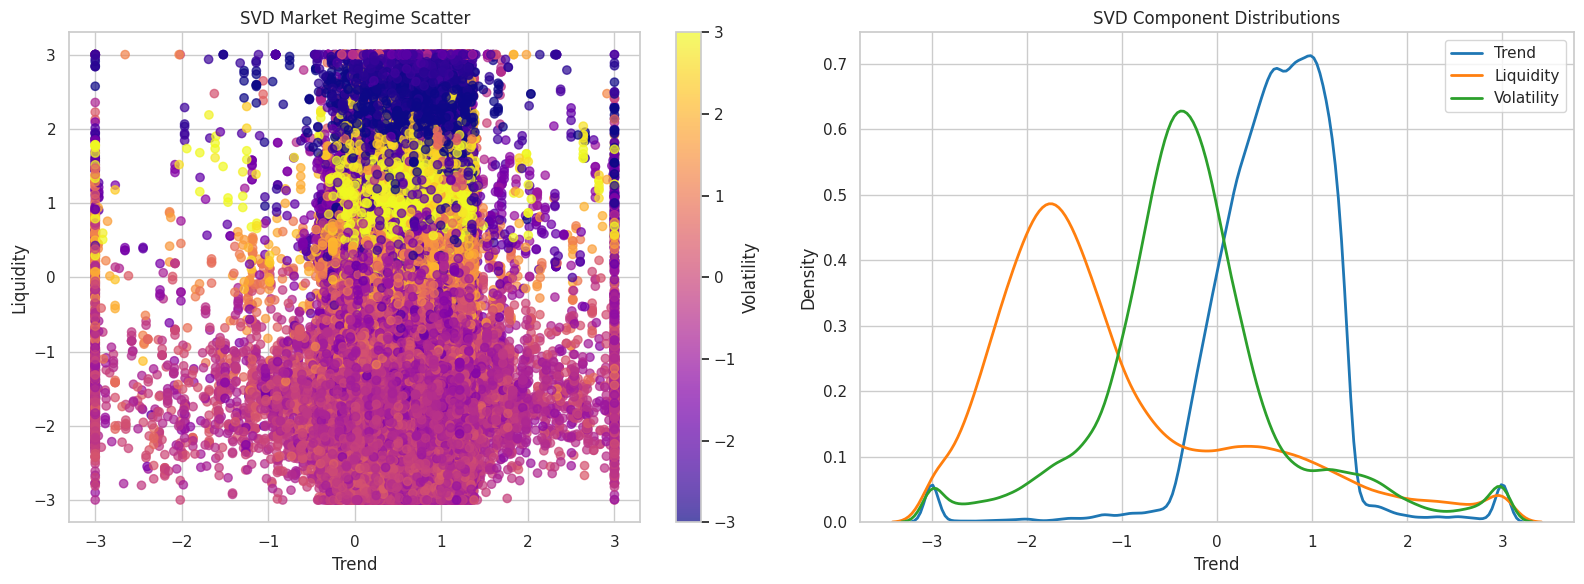

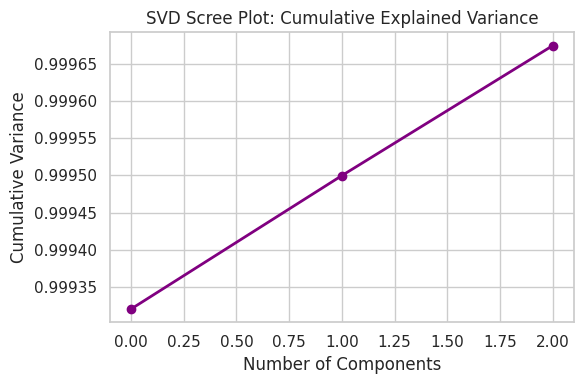

✅ SVD Components saved to 'market_regime_svd_components.csv'


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import kurtosis

sns.set(style="whitegrid")

def market_regime_svd(df):
    """
    Market regime preprocessing using SVD instead of PCA.
    
    Steps:
    - MAD-based outlier clipping
    - Median imputation + RobustScaler
    - Dimensionality reduction using Truncated SVD
    - Final normalization for component comparability
    
    Args:
        df (pd.DataFrame): Input market data (must include 'time' and core features)

    Returns:
        df_svd (pd.DataFrame): Transformed features (Trend, Liquidity, Volatility)
    """

    # -----------------------------
    # 1. Feature Selection
    # -----------------------------
    CORE_FEATURES = [
        'mid_price', 'spread', 
        'total_bid_depth', 'total_ask_depth',
        'return_vol_10s', 'microprice',
        'imbalance_l1', 'volume_imbalance_10s'
    ]
    if not all(f in df.columns for f in CORE_FEATURES):
        raise ValueError("Missing core features in input DataFrame.")
    
    features = df[CORE_FEATURES].copy()
    time_col = df['time'].copy()

    # -----------------------------
    # 2. MAD Outlier Clipping
    # -----------------------------
    for col in features.columns:
        med = features[col].median()
        mad = 1.4826 * np.median(np.abs(features[col] - med))
        features[col] = np.clip(features[col], med - 8 * mad, med + 8 * mad)

    # -----------------------------
    # 3. Preprocessing + SVD Pipeline
    # -----------------------------
    pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        RobustScaler(),
        TruncatedSVD(n_components=3, random_state=42)
    )
    
    X_svd = pipeline.fit_transform(features)
    svd = pipeline.named_steps['truncatedsvd']

    # -----------------------------
    # 4. Post-SVD Normalization
    # -----------------------------
    for i in range(X_svd.shape[1]):
        low, high = np.percentile(X_svd[:, i], [1, 99])
        X_svd[:, i] = np.interp(X_svd[:, i], (low, high), (-3, 3))

    # -----------------------------
    # 5. Create Output
    # -----------------------------
    df_svd = pd.DataFrame(X_svd, columns=['Trend', 'Liquidity', 'Volatility'])
    df_svd['time'] = time_col

    # -----------------------------
    # 6. Diagnostics
    # -----------------------------
    print("="*50)
    print("Explained Variance by SVD Components:")
    for i, ratio in enumerate(svd.explained_variance_ratio_):
        print(f"  Component {i+1}: {ratio:.2%}")
    print(f"  Total: {svd.explained_variance_ratio_.sum():.2%}")
    print("Component Kurtosis:", 
          [f"{kurtosis(X_svd[:,i]):.2f}" for i in range(3)])
    print("="*50)

    # -----------------------------
    # 7. Visualization
    # -----------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 7a. Component Scatter
    scatter = ax1.scatter(df_svd['Trend'], df_svd['Liquidity'], 
                          c=df_svd['Volatility'], cmap='plasma', alpha=0.7)
    ax1.set_title("SVD Market Regime Scatter")
    ax1.set_xlabel("Trend")
    ax1.set_ylabel("Liquidity")
    plt.colorbar(scatter, ax=ax1, label="Volatility")

    # 7b. Component Distributions
    for i, (col, color) in enumerate(zip(['Trend', 'Liquidity', 'Volatility'],
                                         ['#1f77b4', '#ff7f0e', '#2ca02c'])):
        sns.kdeplot(df_svd[col], ax=ax2, label=col, color=color, linewidth=2)
    ax2.set_title("SVD Component Distributions")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Optional Scree Plot
    plt.figure(figsize=(6, 4))
    plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o', linewidth=2, color='purple')
    plt.title("SVD Scree Plot: Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_svd

# Example usage
if __name__ == "__main__":
    df_raw = pd.read_csv("/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/raw_market_features.csv")
    df_svd_components = market_regime_svd(df_raw)
    df_svd_components.to_csv("/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/market_regime_svd_components.csv", index=False)
    print("✅ SVD Components saved to 'market_regime_svd_components.csv'")


task3

[KMeans] Computing optimal K...


[KMeans] Optimal clusters: 3
[HDBSCAN] Running clustering...
[GMM] Running clustering...
[Metrics] Calculating clustering scores...
[Plotting] Visualizing clustering...


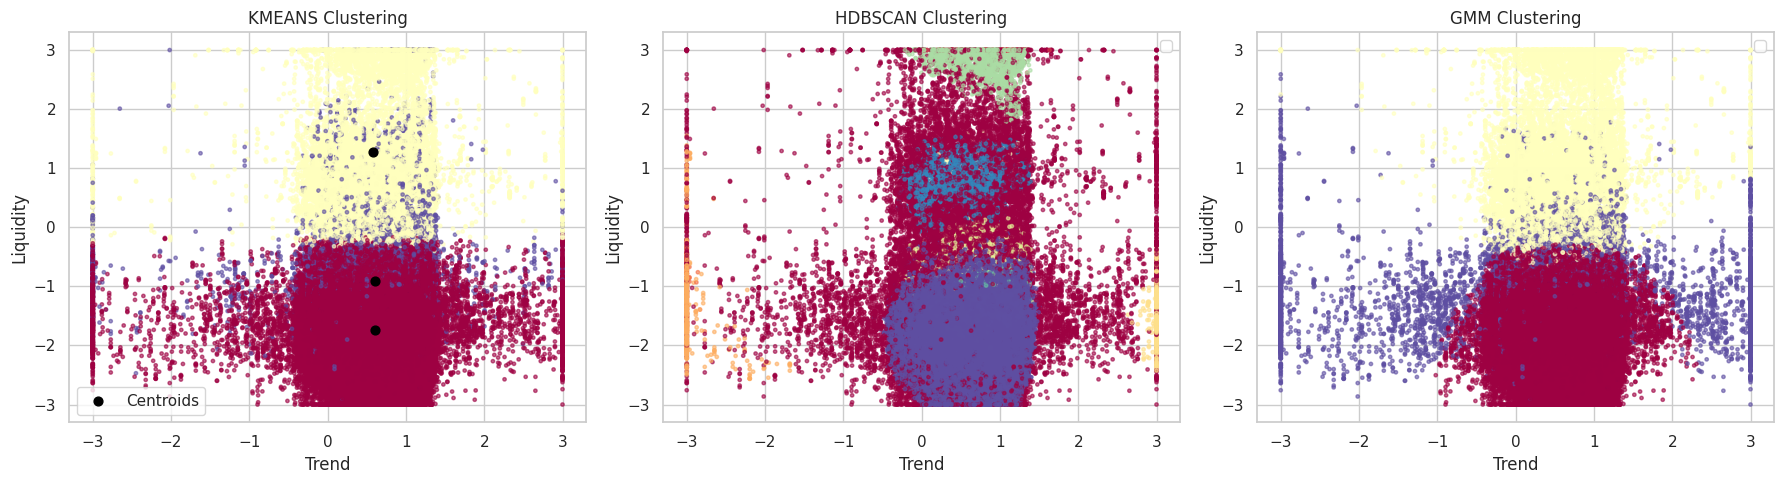


[Done] Clustering Results:
         silhouette  davies_bouldin  n_clusters
kmeans        0.523           0.736         3.0
hdbscan       0.515           0.500        10.0
gmm           0.493           1.012         3.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kneed import KneeLocator
import hdbscan
import warnings

warnings.filterwarnings("ignore")

def load_and_sample_data(path, sample_size=10000):
    df = pd.read_csv(path)
    X = df[['Trend', 'Liquidity', 'Volatility']].values
    if len(X) > sample_size:
        rng = np.random.RandomState(42)
        sample_idx = rng.choice(len(X), sample_size, replace=False)
        return df, X, X[sample_idx]
    return df, X, X

def get_optimal_k(X_sample, max_k=10):
    distortions = []
    K_range = range(2, max_k)
    for k in K_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=5)
        km.fit(X_sample)
        distortions.append(km.inertia_)
    elbow = KneeLocator(K_range, distortions, curve='convex', direction='decreasing')
    return elbow.elbow or 4

def compute_metrics(X, labels):
    if len(np.unique(labels)) > 1 and len(X) == len(labels):
        silhouette = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        return {
            'silhouette': round(silhouette, 3),
            'davies_bouldin': round(db_score, 3),
            'n_clusters': len(np.unique(labels))
        }
    return {}

def plot_clusters(X, labels_dict, centroids=None):
    plt.figure(figsize=(18, 5))
    for i, (method, labels) in enumerate(labels_dict.items()):
        plt.subplot(1, 3, i+1)
        scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Spectral', s=6, alpha=0.6)
        if method == 'kmeans' and centroids is not None:
            plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=40, label='Centroids')
        plt.title(f"{method.upper()} Clustering")
        plt.xlabel("Trend")
        plt.ylabel("Liquidity")
        plt.legend()
    plt.tight_layout()
    plt.show()

def efficient_clustering(pca_results_path, sample_size=10000):
    df, X, X_sample = load_and_sample_data(pca_results_path, sample_size)

    # ---- 1. KMeans ----
    print("[KMeans] Computing optimal K...")
    optimal_k = get_optimal_k(X_sample)
    print(f"[KMeans] Optimal clusters: {optimal_k}")
    km = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = km.fit_predict(X)
    kmeans_centroids = km.cluster_centers_

    # ---- 2. HDBSCAN ----
    print("[HDBSCAN] Running clustering...")
    hdb = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20,
                          core_dist_n_jobs=-1, approx_min_span_tree=True)
    hdb_labels = hdb.fit_predict(X)

    # ---- 3. GMM ----
    print("[GMM] Running clustering...")
    gmm = GaussianMixture(n_components=optimal_k, covariance_type='diag',
                          init_params='kmeans', random_state=42)
    gmm_labels = gmm.fit_predict(X)

    # ---- Store Results ----
    df['kmeans'] = kmeans_labels
    df['hdbscan'] = hdb_labels
    df['gmm'] = gmm_labels

    # ---- Metrics ----
    print("[Metrics] Calculating clustering scores...")
    metrics = {
        'kmeans': compute_metrics(X, kmeans_labels),
        'hdbscan': compute_metrics(X[hdb_labels != -1], hdb_labels[hdb_labels != -1]),  # Ignore noise
        'gmm': compute_metrics(X, gmm_labels)
    }

    # ---- Plotting ----
    print("[Plotting] Visualizing clustering...")
    label_dict = {'kmeans': kmeans_labels, 'hdbscan': hdb_labels, 'gmm': gmm_labels}
    plot_clusters(X, label_dict, centroids=kmeans_centroids)

    print("\n[Done] Clustering Results:")
    print(pd.DataFrame(metrics).T)

    return df, metrics

# Example usage
if __name__ == "__main__":
    df_clusters, metrics = efficient_clustering("/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/market_regime_components.csv")
    df_clusters.to_csv("/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/task3_optimized_clusters.csv", index=False)


task-4

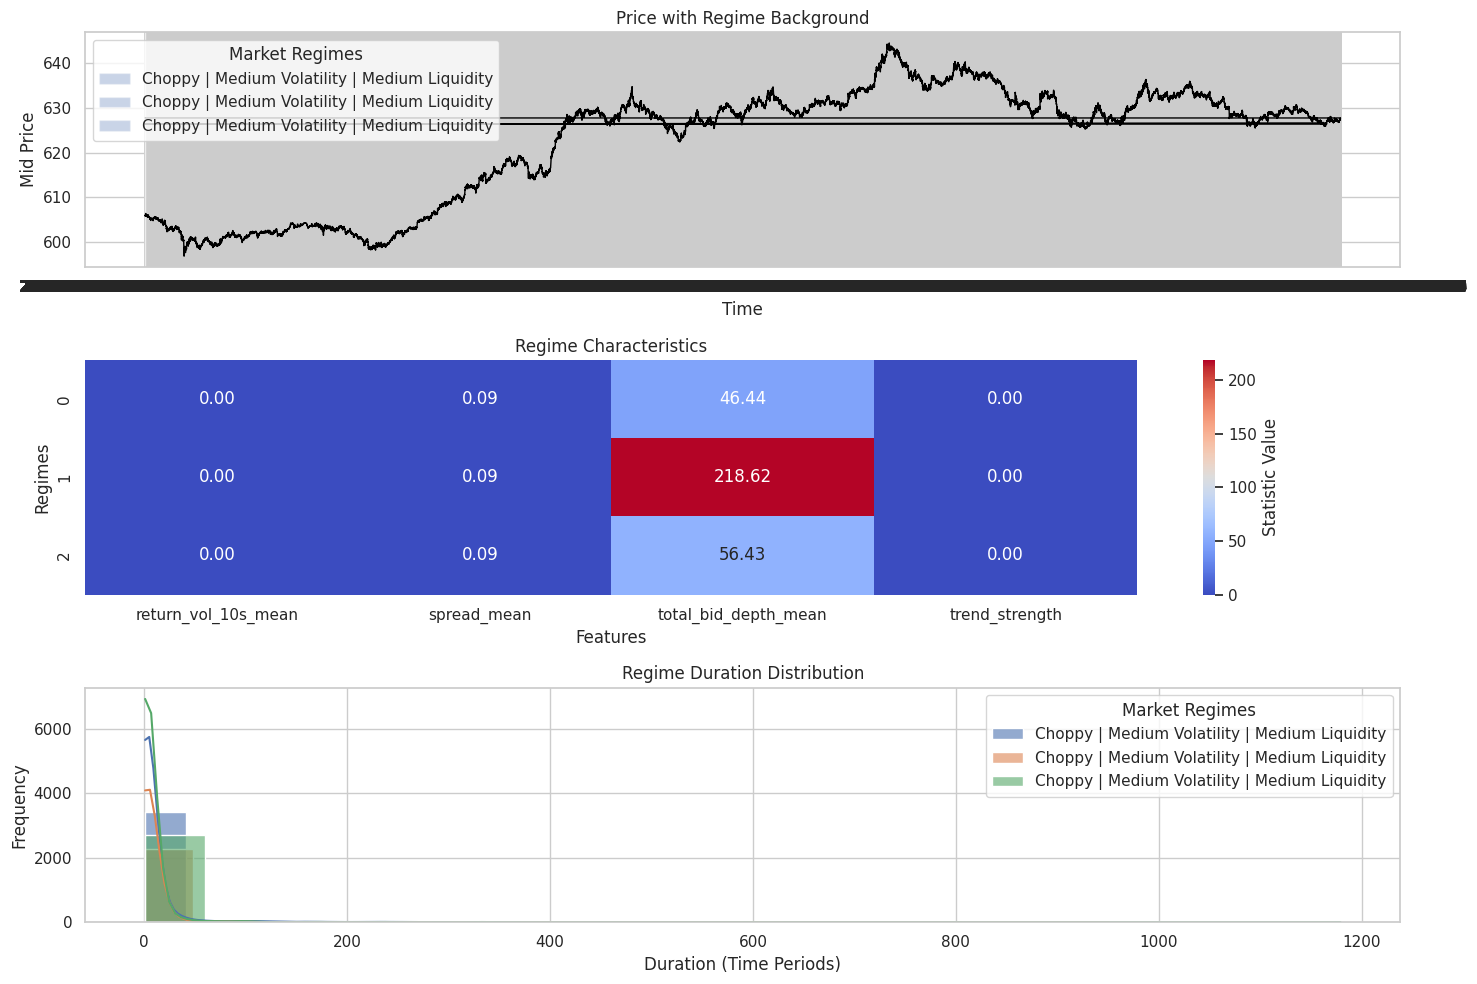


Regime Analysis Complete!
Saved results to labeled_regimes.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_market_regimes(cluster_path, original_data_path):
    """
    Analyze and label market regimes from clustering results.
    Args:
        cluster_path: Path to clustered data (from Task 3)
        original_data_path: Path to original market data
    Returns:
        df_regimes: DataFrame with labeled regimes
        regime_stats: Statistics for each regime
    """
    # Load data
    df_clusters = pd.read_csv(cluster_path)
    df_original = pd.read_csv(original_data_path)
    
    # Merge with original features (ensure no duplications)
    df = pd.merge(df_clusters, df_original, on='time', how='left', suffixes=('_cluster', '_original'))
    
    # Use KMeans clusters as primary regime labels (most stable)
    df['regime'] = df['kmeans']
    
    # 1. Calculate regime statistics (use vectorized operations for better performance)
    regime_stats = {}
    features_to_analyze = [
        'return_vol_10s', 'spread', 
        'total_bid_depth', 'total_ask_depth',
        'mid_price_returns'
    ]
    
    # Loop over each regime to calculate statistics
    for regime in sorted(df['regime'].unique()):
        regime_data = df[df['regime'] == regime]
        stats = {}
        
        # Basic statistics with vectorized operations
        for feature in features_to_analyze:
            if feature in regime_data.columns:
                stats[f'{feature}_mean'] = regime_data[feature].mean()
                stats[f'{feature}_std'] = regime_data[feature].std()
        
        # Price directionality (t-test for trend)
        if 'mid_price_returns' in regime_data.columns:
            _, pvalue = stats.ttest_1samp(regime_data['mid_price_returns'], 0)
            stats['trend_strength'] = (1 - pvalue) * np.sign(regime_data['mid_price_returns'].mean())
        
        regime_stats[regime] = stats
    
    # 2. Create descriptive labels with better decision-making for each characteristic
    regime_labels = {}
    for regime, stats in regime_stats.items():
        # Determine volatility regime
        vol = stats.get('return_vol_10s_mean', 0)
        if vol > df['return_vol_10s'].quantile(0.75):
            vol_label = "High Volatility"
        elif vol < df['return_vol_10s'].quantile(0.25):
            vol_label = "Low Volatility"
        else:
            vol_label = "Medium Volatility"
        
        # Determine liquidity regime
        spread = stats.get('spread_mean', 0)
        depth = stats.get('total_bid_depth_mean', 0) + stats.get('total_ask_depth_mean', 0)
        if spread < df['spread'].quantile(0.25) and depth > df['total_bid_depth'].quantile(0.75):
            liq_label = "High Liquidity"
        elif spread > df['spread'].quantile(0.75) and depth < df['total_bid_depth'].quantile(0.25):
            liq_label = "Low Liquidity"
        else:
            liq_label = "Medium Liquidity"
        
        # Determine price trend
        trend = stats.get('trend_strength', 0)
        if abs(trend) > 0.5:  # Significant trend
            trend_label = "Trending" if trend > 0 else "Mean Reverting"
        else:
            trend_label = "Choppy"
        
        regime_labels[regime] = f"{trend_label} | {vol_label} | {liq_label}"
    
    # 3. Visual analysis (improved chart labeling, heatmap with color and clearer legends)
    plt.figure(figsize=(15, 10))
    
    # Price with regime background
    ax1 = plt.subplot(311)
    for regime in sorted(df['regime'].unique()):
        regime_periods = df[df['regime'] == regime]
        ax1.axvspan(regime_periods['time'].min(), regime_periods['time'].max(), 
                   alpha=0.3, label=regime_labels[regime])
    ax1.plot(df['time'], df['mid_price'], lw=1, color='black')
    ax1.set_title('Price with Regime Background')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Mid Price')
    ax1.legend(title="Market Regimes", loc='upper left')
    
    # Regime statistics heatmap with improved color and axis labels
    ax2 = plt.subplot(312)
    stats_df = pd.DataFrame(regime_stats).T

    # Ensure all expected columns are present and fill missing ones
    expected_cols = ['return_vol_10s_mean', 'spread_mean', 
                    'total_bid_depth_mean', 'trend_strength']
    for col in expected_cols:
        if col not in stats_df.columns:
            stats_df[col] = np.nan

    stats_df = stats_df[expected_cols].fillna(0)

    sns.heatmap(stats_df, annot=True, fmt=".2f", ax=ax2, cmap="coolwarm", cbar_kws={'label': 'Statistic Value'})
    ax2.set_title('Regime Characteristics')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Regimes')
    
    # Regime duration analysis (better histogram clarity and title)
    ax3 = plt.subplot(313)
    regime_changes = df['regime'].ne(df['regime'].shift()).cumsum()
    regime_durations = df.groupby(regime_changes)['time'].agg(['first', 'count'])
    for regime in sorted(df['regime'].unique()):
        durations = regime_durations[df.loc[regime_durations.index, 'regime'] == regime]['count']
        sns.histplot(durations, ax=ax3, label=regime_labels[regime], alpha=0.6, bins=20, kde=True)
    ax3.set_xlabel('Duration (Time Periods)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Regime Duration Distribution')
    ax3.legend(title="Market Regimes")
    
    plt.tight_layout()
    plt.show()
    
    # Add labels to dataframe
    df['regime_label'] = df['regime'].map(regime_labels)
    
    # Save results
    df.to_csv("labeled_regimes.csv", index=False)
    
    return df, regime_stats

# Execute analysis
if __name__ == "__main__":
    df_regimes, stats = analyze_market_regimes(
        "/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/task3_optimized_clusters.csv", 
        "/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/raw_market_features.csv"
    )
    print("\nRegime Analysis Complete!")
    print("Saved results to labeled_regimes.csv")


task-5

Loading data...
Merging...
Plotting regime evolution with price...


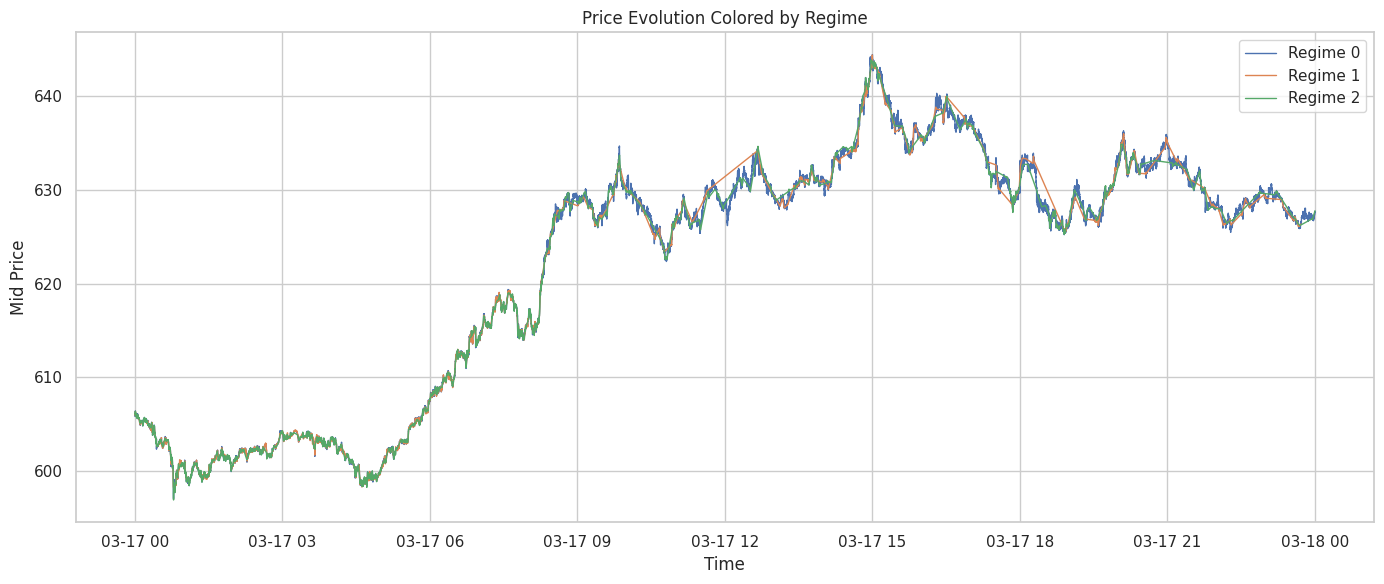

Plotting regime label vs time with volatility...


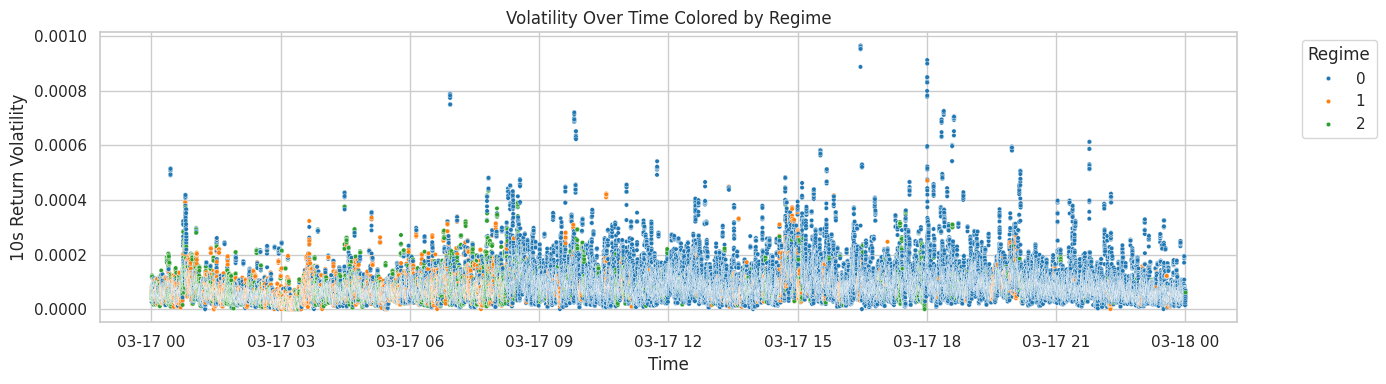

Running t-SNE...
Plotting t-SNE...


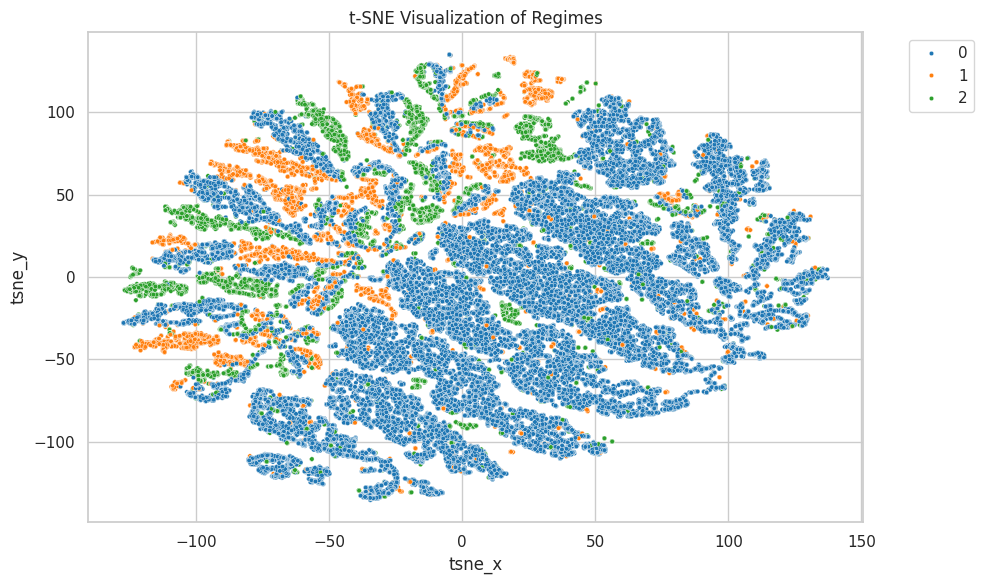

Running UMAP...
Plotting UMAP...


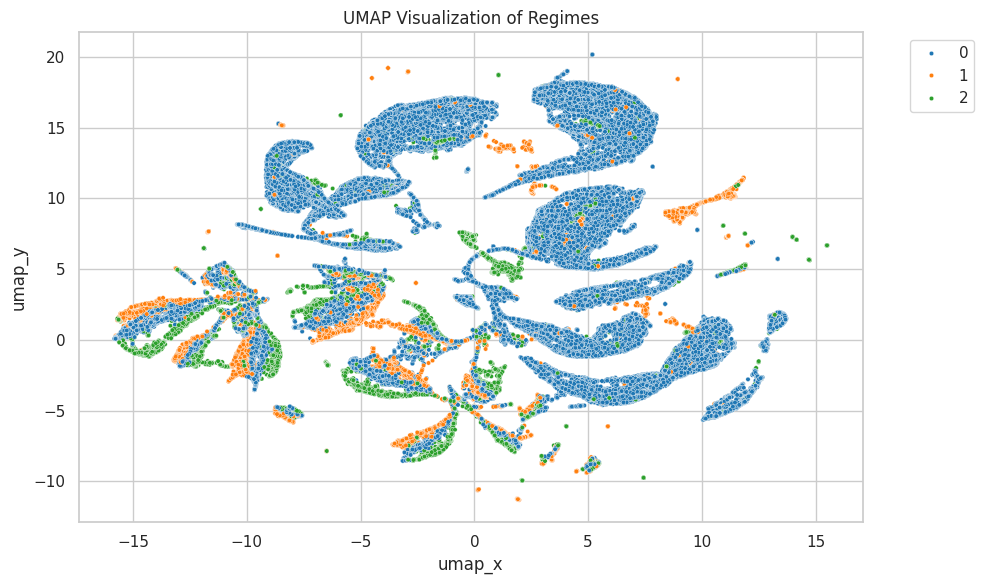

✅ Visualization Complete.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

def task5_visualization(cluster_path, original_data_path):
    print("Loading data...")
    df_clusters = pd.read_csv(cluster_path)
    df_original = pd.read_csv(original_data_path)

    print("Merging...")
    df = pd.merge(df_clusters, df_original, on='time', how='left')
    df['regime'] = df['kmeans']
    
    # Optional: label map from Task 4 (can reuse if saved or regenerate)
    regime_map = {i: f"Regime {i}" for i in sorted(df['regime'].unique())}
    df['regime_label'] = df['regime'].map(regime_map)

    # Convert time to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'], errors='coerce')

    # --- 1. Regime Evolution Over Time with Price ---
    print("Plotting regime evolution with price...")
    plt.figure(figsize=(14, 6))
    for regime in sorted(df['regime'].unique()):
        regime_df = df[df['regime'] == regime]
        plt.plot(regime_df['time'], regime_df['mid_price'], label=regime_map[regime], lw=1)
    plt.xlabel('Time')
    plt.ylabel('Mid Price')
    plt.title('Price Evolution Colored by Regime')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 2. Regime vs Time Heatmap with Volatility Overlay ---
    print("Plotting regime label vs time with volatility...")
    plt.figure(figsize=(14, 4))
    sns.scatterplot(data=df, x='time', y='return_vol_10s', hue='regime', palette='tab10', s=10)
    plt.title('Volatility Over Time Colored by Regime')
    plt.xlabel('Time')
    plt.ylabel('10s Return Volatility')
    plt.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 3. Dimensionality Reduction: t-SNE ---
    print("Running t-SNE...")
    features = ['mid_price', 'return_vol_10s', 'spread', 'total_bid_depth', 'total_ask_depth']
    features = [f for f in features if f in df.columns]
    X = df[features].fillna(0)
    X_scaled = StandardScaler().fit_transform(X)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    df['tsne_x'], df['tsne_y'] = X_tsne[:, 0], X_tsne[:, 1]

    print("Plotting t-SNE...")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='tsne_x', y='tsne_y', hue='regime', data=df, palette='tab10', s=10)
    plt.title('t-SNE Visualization of Regimes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 4. Dimensionality Reduction: UMAP ---
    print("Running UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    df['umap_x'], df['umap_y'] = X_umap[:, 0], X_umap[:, 1]

    print("Plotting UMAP...")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='umap_x', y='umap_y', hue='regime', data=df, palette='tab10', s=10)
    plt.title('UMAP Visualization of Regimes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("✅ Visualization Complete.")

# Run Task 5
if __name__ == "__main__":
    task5_visualization("/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/task3_optimized_clusters.csv", "/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/raw_market_features.csv")


task-6

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def task6_detailed_regime_transition_analysis(cluster_data_path, regime_mapping):
    # Load Data
    print("Loading data...")
    df = pd.read_csv(cluster_data_path)
    
    # Convert to datetime & sort
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df = df.sort_values('time')

    # Map to interpretable regimes
    df['regime_full'] = df['kmeans'].map(regime_mapping)

    # Drop NaN if any unmapped
    df = df.dropna(subset=['regime_full'])

    # Extract transitions
    regimes = df['regime_full'].tolist()
    transitions = {}
    for i in range(len(regimes) - 1):
        curr = regimes[i]
        next_ = regimes[i + 1]
        if curr not in transitions:
            transitions[curr] = {}
        transitions[curr][next_] = transitions[curr].get(next_, 0) + 1

    # Convert to probability matrix
    all_regimes = sorted(set(regimes))
    transition_matrix = pd.DataFrame(0.0, index=all_regimes, columns=all_regimes)
    for curr_state, next_states in transitions.items():
        total_transitions = sum(next_states.values())
        for next_state, count in next_states.items():
            transition_matrix.loc[curr_state, next_state] = count / total_transitions

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title("Transition Probabilities Between Market Regimes")
    plt.xlabel("Next Regime")
    plt.ylabel("Current Regime")
    plt.tight_layout()
    plt.show()

    print("✅ Transition analysis complete.")
    return transition_matrix


Loading data...


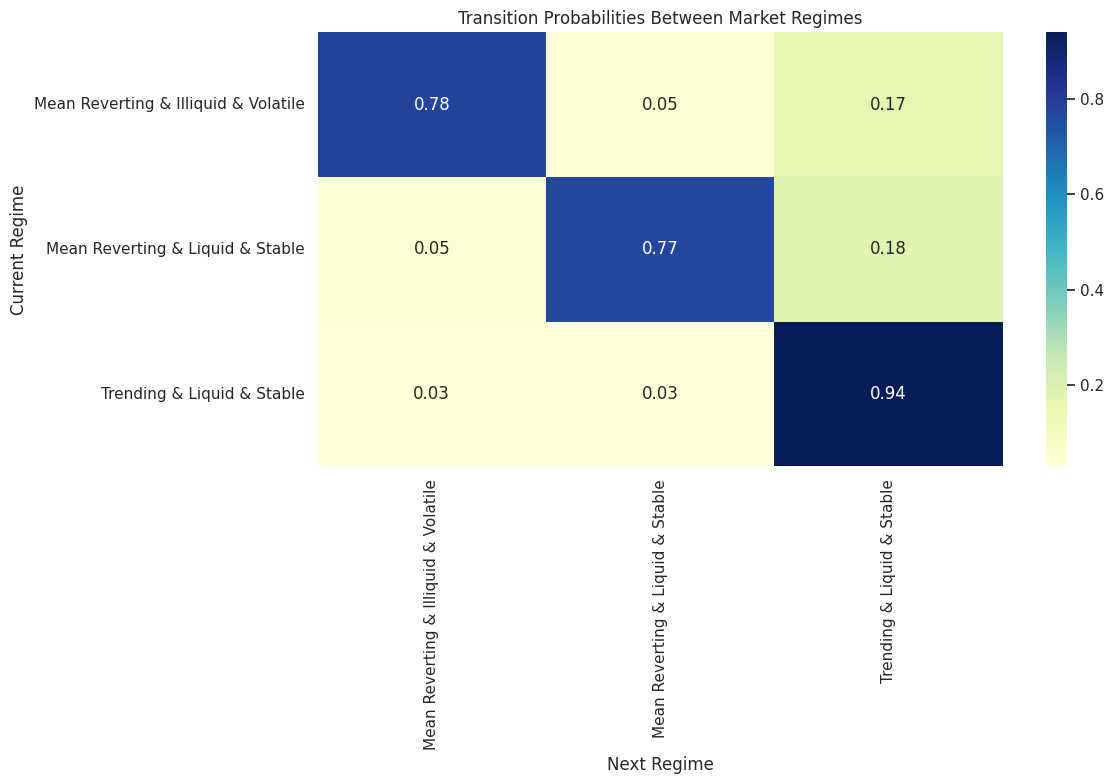

✅ Transition analysis complete.


In [9]:
if __name__ == "__main__":
    regime_map = {
        0: "Trending & Liquid & Stable",
        1: "Mean Reverting & Illiquid & Volatile",
        2: "Mean Reverting & Liquid & Stable"
        # Add more if you have more clusters
    }

    transition_matrix = task6_detailed_regime_transition_analysis(
        cluster_data_path="/home/SPAI_ons/health_ai/Tauheed/gfactor2/hidden17/task3_optimized_clusters.csv",
        regime_mapping=regime_map
    )
